# 🧠 CNN Deforestation Detection Pipeline
## Patch-based 2D CNN với Spatial Context

**Dự án:** Ứng dụng Viễn thám và Học sâu trong Giám sát Biến động Rừng tỉnh Cà Mau

**Sinh viên:** Ninh Hải Đăng (MSSV: 21021411)

---

## 📋 Pipeline Overview

1. **Setup & Import Libraries**
2. **Load Data** - Sentinel-1, Sentinel-2, Ground Truth
3. **Feature Extraction** - 27 features
4. **Spatial-Aware Data Splitting** - Tránh data leakage
5. **Extract Patches** - 3×3 patches tại ground truth points
6. **Train CNN Model** - Lightweight 2D CNN
7. **Evaluate Model** - Test set metrics
8. **Predict Full Raster** - Classification + Probability maps
9. **Visualization** - Results analysis
10. **Summary** - Final results

---
## 1️⃣ Setup & Import Libraries

In [1]:
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Geospatial
import rasterio
from rasterio.plot import show

# Sklearn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report
)

# Check PyTorch and CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("Using CPU")
    device = 'cpu'

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

print("\n✓ Libraries imported successfully!")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1060 6GB

✓ Libraries imported successfully!


### Configuration

In [2]:
# Configuration
CONFIG = {
    # Model
    'patch_size': 3,
    'n_features': 27,
    'n_classes': 2,
    'dropout_rate': 0.5,
    
    # Training
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'early_stopping_patience': 10,
    
    # Spatial split
    'cluster_distance': 50.0,
    'train_size': 0.70,
    'val_size': 0.15,
    'test_size': 0.15,
    
    # Device
    'device': device,
    
    # Prediction
    'pred_batch_size': 1000,
    'pred_stride': 1,
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key:25s}: {value}")

Configuration:
  patch_size               : 3
  n_features               : 27
  n_classes                : 2
  dropout_rate             : 0.5
  epochs                   : 50
  batch_size               : 32
  learning_rate            : 0.001
  weight_decay             : 0.0001
  early_stopping_patience  : 10
  cluster_distance         : 50.0
  train_size               : 0.7
  val_size                 : 0.15
  test_size                : 0.15
  device                   : cuda
  pred_batch_size          : 1000
  pred_stride              : 1


---
## 2️⃣ Load Data

In [3]:
from common.data_loader import DataLoader

print("Loading data...")
loader = DataLoader()

# Load all data
s2_before, s2_after = loader.load_sentinel2()
s1_before, s1_after = loader.load_sentinel1()
ground_truth = loader.load_ground_truth()
boundary = loader.load_boundary()

# Store metadata
metadata = loader.metadata

print("\n✓ Data loaded successfully!")
print(f"\nGround truth points: {len(ground_truth)}")
print(f"Class distribution:")
print(ground_truth['label'].value_counts())

2025-11-08 00:36:26 - common.data_loader - INFO - 
2025-11-08 00:36:26 - common.data_loader - INFO - LOADING SENTINEL-2 DATA (OPTICAL)
2025-11-08 00:36:26 - common.data_loader - INFO - ======================================================================
2025-11-08 00:36:26 - common.data_loader - INFO - Loading Sentinel-2 Before (2024-01-30): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-2\S2_2024_01_30.tif


Loading data...


2025-11-08 00:36:49 - common.data_loader - INFO -   [OK] Shape: (7, 10917, 12547)
2025-11-08 00:36:49 - common.data_loader - INFO -   [OK] Bands: 7
2025-11-08 00:36:49 - common.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-08 00:36:49 - common.data_loader - INFO -   [OK] NoData: 0.0
2025-11-08 00:37:00 - common.data_loader - INFO - Loading Sentinel-2 After (2025-02-28): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-2\S2_2025_02_28.tif
2025-11-08 00:37:25 - common.data_loader - INFO -   [OK] Shape: (7, 10917, 12547)
2025-11-08 00:37:25 - common.data_loader - INFO -   [OK] Bands: 7
2025-11-08 00:37:25 - common.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-08 00:37:25 - common.data_loader - INFO -   [OK] NoData: 0.0
2025-11-08 00:37:37 - common.data_loader - INFO - 
[OK] Sentinel-2 data loaded successfully
2025-11-08 00:37:37 - common.data_loader - INFO -   - Expected bands: ['B4', 'B8', 'B11', 'B12', 'NDVI', 'NBR', 'NDMI']
2025-11-08 00:37:37 - common.data_l


✓ Data loaded successfully!

Ground truth points: 1285
Class distribution:
label
0    650
1    635
Name: count, dtype: int64


---
## 3️⃣ Feature Extraction

In [4]:
from common.feature_extraction import FeatureExtraction

print("Extracting features...")
extractor = FeatureExtraction()

feature_stack, valid_mask = extractor.extract_features(
    s2_before, s2_after,
    s1_before, s1_after
)

print(f"\n✓ Feature extraction completed!")
print(f"Feature stack shape: {feature_stack.shape}")
print(f"Valid pixels: {valid_mask.sum():,} / {valid_mask.size:,} ({valid_mask.sum()/valid_mask.size*100:.2f}%)")

2025-11-08 00:37:55 - common.feature_extraction - INFO - 
2025-11-08 00:37:55 - common.feature_extraction - INFO - STEP 3: FEATURE EXTRACTION
2025-11-08 00:37:55 - common.feature_extraction - INFO - ======================================================================
2025-11-08 00:37:55 - common.feature_extraction - INFO - 
Input dimensions: 10917 x 12547
2025-11-08 00:37:55 - common.feature_extraction - INFO - 
Creating valid pixel mask...


Extracting features...


2025-11-08 00:38:02 - common.feature_extraction - INFO -   ✓ Valid pixels: 15,569,516 / 136,975,599 (11.37%)
2025-11-08 00:38:02 - common.feature_extraction - INFO - 
Engineering Sentinel-2 features...
2025-11-08 00:38:02 - common.feature_extraction - INFO -   - Adding S2 Before bands (7 features)
2025-11-08 00:38:02 - common.feature_extraction - INFO -   - Adding S2 After bands (7 features)
2025-11-08 00:38:02 - common.feature_extraction - INFO -   - Calculating S2 Delta (7 features)
2025-11-08 00:38:04 - common.feature_extraction - INFO -   ✓ Total S2 features: 21
2025-11-08 00:38:04 - common.feature_extraction - INFO - 
Engineering Sentinel-1 features...
2025-11-08 00:38:04 - common.feature_extraction - INFO -   - Adding S1 Before bands (2 features)
2025-11-08 00:38:04 - common.feature_extraction - INFO -   - Adding S1 After bands (2 features)
2025-11-08 00:38:04 - common.feature_extraction - INFO -   - Calculating S1 Delta (2 features)
2025-11-08 00:38:04 - common.feature_extractio


✓ Feature extraction completed!
Feature stack shape: (27, 10917, 12547)
Valid pixels: 15,569,516 / 136,975,599 (11.37%)


---
## 4️⃣ Spatial-Aware Data Splitting

**Mục đích:** Tránh data leakage khi có points gần nhau

In [5]:
from deep_learning.spatial_split import SpatialSplitter

print("Performing spatial-aware splitting...")
splitter = SpatialSplitter(
    cluster_distance=CONFIG['cluster_distance'],
    train_size=CONFIG['train_size'],
    val_size=CONFIG['val_size'],
    test_size=CONFIG['test_size'],
    random_state=RANDOM_STATE
)

train_indices, val_indices, test_indices, split_metadata = splitter.spatial_split(
    ground_truth,
    stratify_by_class=True,
    verify=True
)

print(f"\n✓ Spatial splitting completed!")

2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - 
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - SPATIAL CLUSTERING
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - ======================================================================
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - Cluster distance threshold: 50.0m
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - 
Clustering results:
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO -   Total points: 1285
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO -   Number of clusters: 1272
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO -   Singleton clusters (size=1): 1259
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO -   Multi-point clusters (size>1): 13
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO -   Max cluster size: 2
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO -   Mean cluster size: 1.01
2025-11-08 00:38:20 - deep_learning.s

Performing spatial-aware splitting...


2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - Created 1272 clusters for splitting
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - 
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - SPLIT STATISTICS
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - ======================================================================
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - Total points: 1285
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO - 
Train set:
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO -   Points: 899 (69.96%)
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO -   Clusters: 890
2025-11-08 00:38:20 - deep_learning.spatial_split - INFO -   Class 0: 455
2025-11-08 00:38:21 - deep_learning.spatial_split - INFO -   Class 1: 444
2025-11-08 00:38:21 - deep_learning.spatial_split - INFO - 
Validation set:
2025-11-08 00:38:21 - deep_learning.spatial_split - INFO -   Points: 193 (15.02%)
2025-11-08 00:38:21 - deep_


✓ Spatial splitting completed!


---
## 5️⃣ Extract Patches

Trích xuất patches 3×3 tại ground truth locations

In [6]:
from deep_learning.patch_extractor import PatchExtractor

print("Extracting patches...")
patch_extractor = PatchExtractor(patch_size=CONFIG['patch_size'])

all_patches, all_labels, valid_gt_indices = patch_extractor.extract_patches_at_points(
    feature_stack,
    ground_truth,
    metadata['s2_before']['transform'],
    valid_mask
)

# Normalize patches and SAVE normalization stats
all_patches, normalization_stats = patch_extractor.normalize_patches(method='standardize')

print(f"\n✓ Patch extraction completed!")
print(f"Patches shape: {all_patches.shape}")
print(f"Labels shape: {all_labels.shape}")
print(f"\n✓ Normalization stats saved for prediction!")
print(f"  Mean shape: {normalization_stats['mean'].shape}")
print(f"  Std shape: {normalization_stats['std'].shape}")

2025-11-08 00:38:25 - deep_learning.patch_extractor - INFO - 
2025-11-08 00:38:25 - deep_learning.patch_extractor - INFO - EXTRACTING PATCHES AT GROUND TRUTH POINTS
2025-11-08 00:38:25 - deep_learning.patch_extractor - INFO - ======================================================================
2025-11-08 00:38:25 - deep_learning.patch_extractor - INFO - Feature stack shape: (27, 10917, 12547)
2025-11-08 00:38:25 - deep_learning.patch_extractor - INFO - Patch size: 3x3
2025-11-08 00:38:25 - deep_learning.patch_extractor - INFO - Ground truth points: 1285


Extracting patches...


2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - 
2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - PATCH EXTRACTION SUMMARY
2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - ======================================================================
2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - Total ground truth points: 1285
2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - Valid patches extracted: 1188
2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - Skipped (edge): 0
2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - Skipped (NoData): 97
2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - Success rate: 92.45%
2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - 
Patch shape: (1188, 3, 3, 27)
2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - Labels shape: (1188,)
2025-11-08 00:38:26 - deep_learning.patch_extractor - INFO - 
Class distribution:
2025-11-08 00:38:26 - deep_learning.


✓ Patch extraction completed!
Patches shape: (1188, 3, 3, 27)
Labels shape: (1188,)

✓ Normalization stats saved for prediction!
  Mean shape: (1, 1, 1, 27)
  Std shape: (1, 1, 1, 27)


### Split patches according to spatial split

In [7]:
# Map original indices to patch indices
index_mapping = {orig_idx: patch_idx for patch_idx, orig_idx in enumerate(valid_gt_indices)}

# Get patches for each split
train_patch_indices = [index_mapping[i] for i in train_indices if i in index_mapping]
val_patch_indices = [index_mapping[i] for i in val_indices if i in index_mapping]
test_patch_indices = [index_mapping[i] for i in test_indices if i in index_mapping]

X_train = all_patches[train_patch_indices]
y_train = all_labels[train_patch_indices]
X_val = all_patches[val_patch_indices]
y_val = all_labels[val_patch_indices]
X_test = all_patches[test_patch_indices]
y_test = all_labels[test_patch_indices]

print(f"\nData split:")
print(f"  Train: {len(X_train)} patches ({len(X_train)/len(all_patches)*100:.1f}%)")
print(f"  Val:   {len(X_val)} patches ({len(X_val)/len(all_patches)*100:.1f}%)")
print(f"  Test:  {len(X_test)} patches ({len(X_test)/len(all_patches)*100:.1f}%)")

print(f"\nClass distribution:")
print(f"  Train - Class 0: {(y_train==0).sum()}, Class 1: {(y_train==1).sum()}")
print(f"  Val   - Class 0: {(y_val==0).sum()}, Class 1: {(y_val==1).sum()}")
print(f"  Test  - Class 0: {(y_test==0).sum()}, Class 1: {(y_test==1).sum()}")


Data split:
  Train: 826 patches (69.5%)
  Val:   183 patches (15.4%)
  Test:  179 patches (15.1%)

Class distribution:
  Train - Class 0: 420, Class 1: 406
  Val   - Class 0: 98, Class 1: 85
  Test  - Class 0: 92, Class 1: 87


---
## 6️⃣ Create CNN Model

In [8]:
from deep_learning.cnn_model import create_model

print("Creating CNN model...")
model = create_model(
    model_type='standard',
    patch_size=CONFIG['patch_size'],
    n_features=CONFIG['n_features'],
    n_classes=CONFIG['n_classes'],
    dropout_rate=CONFIG['dropout_rate']
)

print(model.get_model_summary())

# Calculate class weights
unique, counts = np.unique(y_train, return_counts=True)
class_weights = [len(y_train) / (len(unique) * c) for c in counts]
print(f"\nClass weights: {class_weights}")

Creating CNN model...
DeforestationCNN Model Architecture
Input shape: (batch, 3, 3, 27)
Output shape: (batch, 2)

Total parameters: 36,546

Layer details:
  Conv1: 27 -> 64 channels (3x3)
  Conv2: 64 -> 32 channels (3x3)
  Global Avg Pool
  FC1: 32 -> 64
  FC2: 64 -> 2

Class weights: [np.float64(0.9833333333333333), np.float64(1.0172413793103448)]


---
## 7️⃣ Train CNN Model

In [9]:
from deep_learning.train import CNNTrainer

print("Initializing trainer...")
trainer = CNNTrainer(
    model=model,
    device=CONFIG['device'],
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    class_weights=class_weights
)

print("\nStarting training...")
print("(This may take 15-20 minutes with GPU, or 30-40 minutes with CPU)\n")

training_start = time.time()

history = trainer.fit(
    X_train, y_train,
    X_val, y_val,
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    early_stopping_patience=CONFIG['early_stopping_patience']
)

training_time = time.time() - training_start
print(f"\n✓ Training completed in {training_time/60:.2f} minutes")

Initializing trainer...


2025-11-08 00:38:29 - deep_learning.train - INFO - Trainer initialized on device: cuda
2025-11-08 00:38:29 - deep_learning.train - INFO - Model parameters: 36,546
2025-11-08 00:38:29 - deep_learning.train - INFO - 
2025-11-08 00:38:29 - deep_learning.train - INFO - STARTING CNN TRAINING
2025-11-08 00:38:29 - deep_learning.train - INFO - ======================================================================
2025-11-08 00:38:29 - deep_learning.train - INFO - Training samples: 826
2025-11-08 00:38:29 - deep_learning.train - INFO - Validation samples: 183
2025-11-08 00:38:29 - deep_learning.train - INFO - Epochs: 50
2025-11-08 00:38:29 - deep_learning.train - INFO - Batch size: 32
2025-11-08 00:38:29 - deep_learning.train - INFO - Learning rate: 0.001
2025-11-08 00:38:29 - deep_learning.train - INFO - Device: cuda
2025-11-08 00:38:29 - deep_learning.train - INFO - ======================================================================




Starting training...
(This may take 15-20 minutes with GPU, or 30-40 minutes with CPU)



2025-11-08 00:38:31 - deep_learning.train - INFO - Epoch   1/50 | Train Loss: 0.3594 | Train Acc:  83.29% | Val Loss: 0.0848 | Val Acc:  98.36% | LR: 0.001000
2025-11-08 00:38:31 - deep_learning.train - INFO -   → New best model! Val Loss: 0.0848, Val Acc: 98.36%
2025-11-08 00:38:31 - deep_learning.train - INFO - Epoch   2/50 | Train Loss: 0.1716 | Train Acc:  94.79% | Val Loss: 0.0630 | Val Acc:  99.45% | LR: 0.001000
2025-11-08 00:38:31 - deep_learning.train - INFO -   → New best model! Val Loss: 0.0630, Val Acc: 99.45%
2025-11-08 00:38:31 - deep_learning.train - INFO - Epoch   3/50 | Train Loss: 0.1228 | Train Acc:  96.00% | Val Loss: 0.0587 | Val Acc:  98.91% | LR: 0.001000
2025-11-08 00:38:31 - deep_learning.train - INFO -   → New best model! Val Loss: 0.0587, Val Acc: 98.91%
2025-11-08 00:38:31 - deep_learning.train - INFO - Epoch   4/50 | Train Loss: 0.1132 | Train Acc:  96.37% | Val Loss: 0.0560 | Val Acc:  98.36% | LR: 0.001000
2025-11-08 00:38:31 - deep_learning.train - INFO 


✓ Training completed in 0.10 minutes


### Plot Training Curves

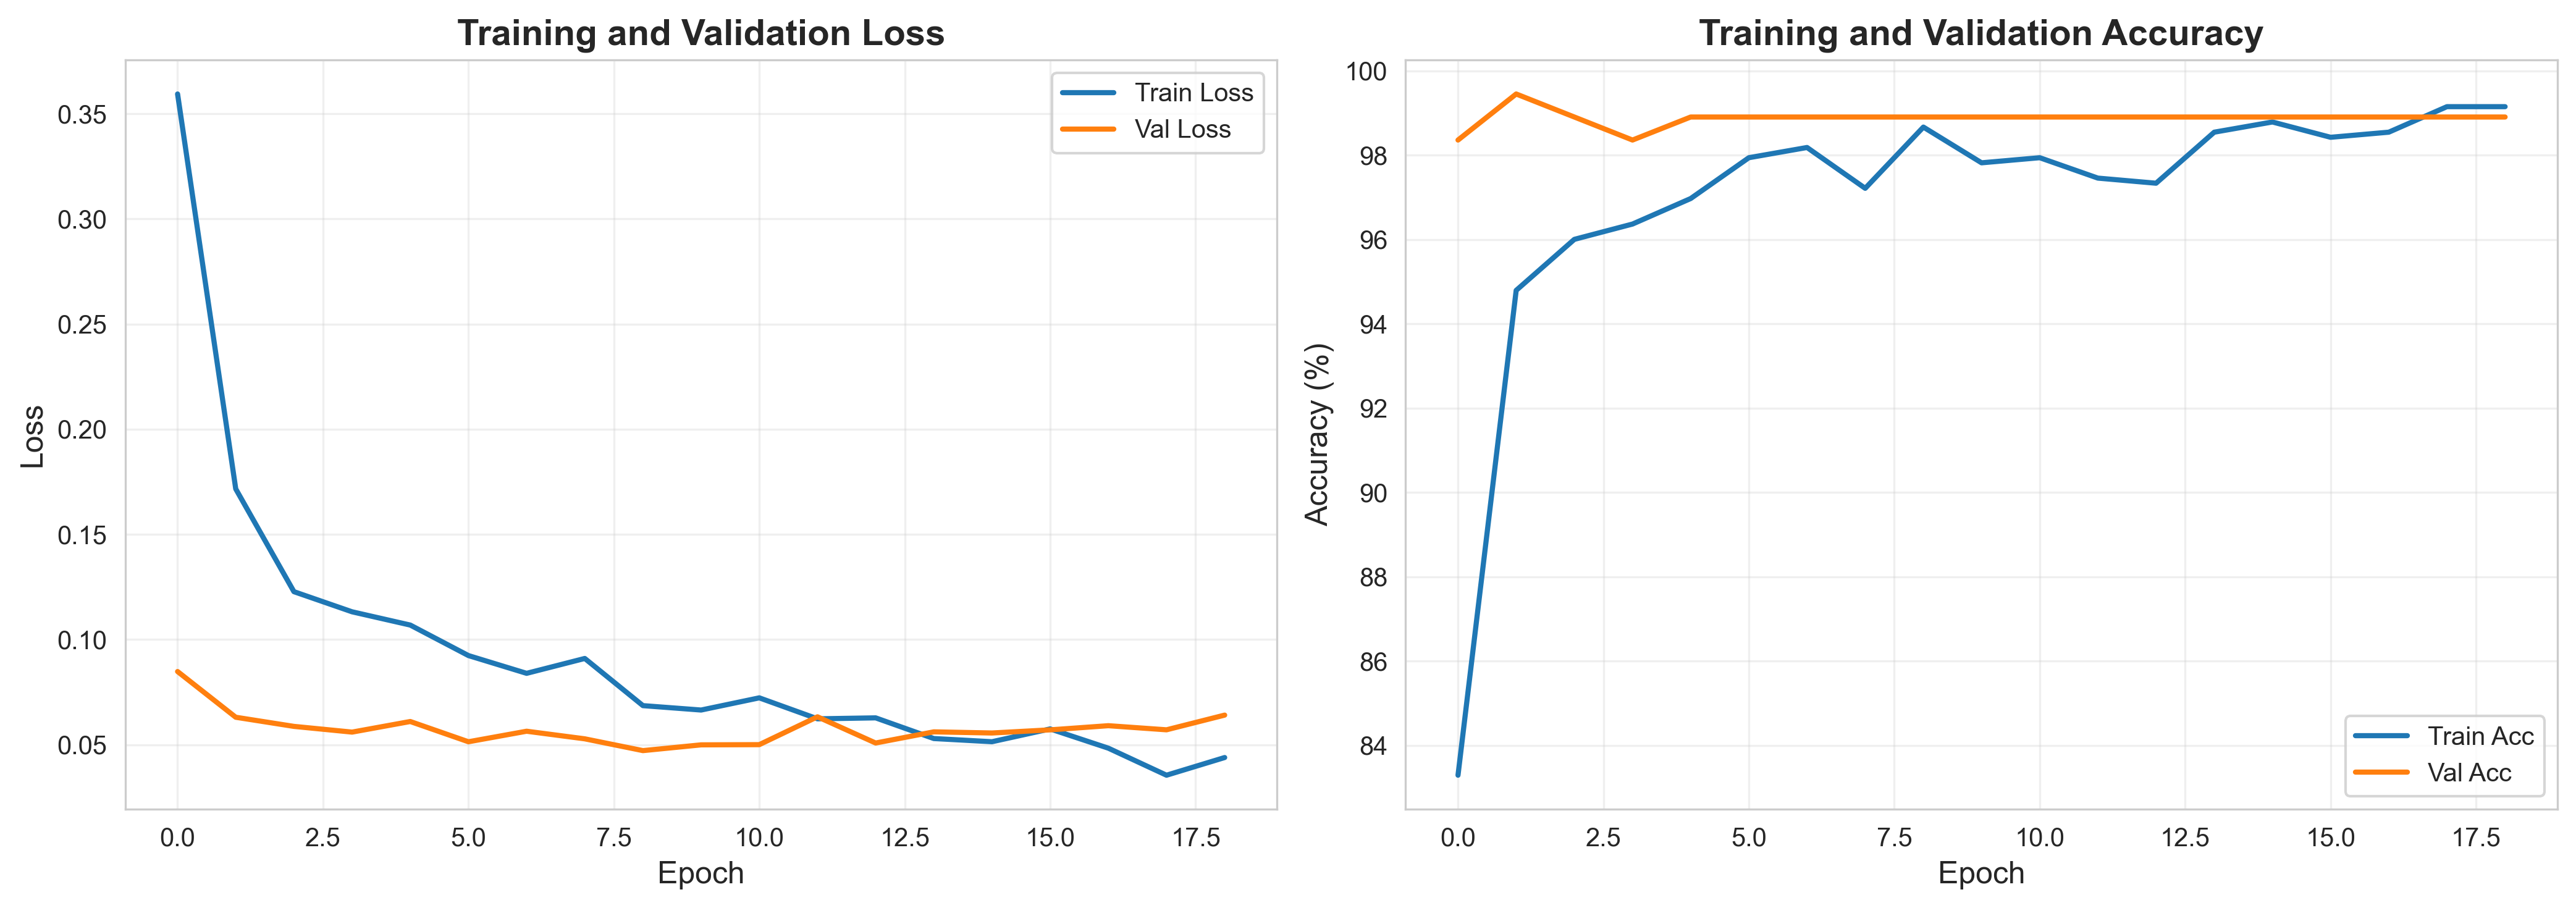

Best validation loss: 0.0472
Best validation accuracy: 99.45%


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/cnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best validation loss: {min(history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(history['val_acc']):.2f}%")

---
## 8️⃣ Evaluate on Test Set

In [11]:
print("Evaluating on test set...")
test_metrics = trainer.evaluate(X_test, y_test, batch_size=CONFIG['batch_size'])

print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print(f"Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"Precision: {test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)")
print(f"Recall:    {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"F1-Score:  {test_metrics['f1_score']:.4f} ({test_metrics['f1_score']*100:.2f}%)")
print(f"ROC-AUC:   {test_metrics['roc_auc']:.4f} ({test_metrics['roc_auc']*100:.2f}%)")
print("="*70)

2025-11-08 00:38:38 - deep_learning.train - INFO - 
2025-11-08 00:38:38 - deep_learning.train - INFO - EVALUATING ON TEST SET
2025-11-08 00:38:38 - deep_learning.train - INFO - ======================================================================
2025-11-08 00:38:38 - deep_learning.train - INFO - 
Test Set Metrics:
2025-11-08 00:38:38 - deep_learning.train - INFO -   Accuracy:  0.9832 (98.32%)
2025-11-08 00:38:38 - deep_learning.train - INFO -   Precision: 0.9667 (96.67%)
2025-11-08 00:38:38 - deep_learning.train - INFO -   Recall:    1.0000 (100.00%)
2025-11-08 00:38:38 - deep_learning.train - INFO -   F1-Score:  0.9831 (98.31%)
2025-11-08 00:38:38 - deep_learning.train - INFO -   ROC-AUC:   0.9936 (99.36%)
2025-11-08 00:38:38 - deep_learning.train - INFO - ======================================================================



Evaluating on test set...

TEST SET PERFORMANCE
Accuracy:  0.9832 (98.32%)
Precision: 0.9667 (96.67%)
Recall:    1.0000 (100.00%)
F1-Score:  0.9831 (98.31%)
ROC-AUC:   0.9936 (99.36%)


### Confusion Matrix

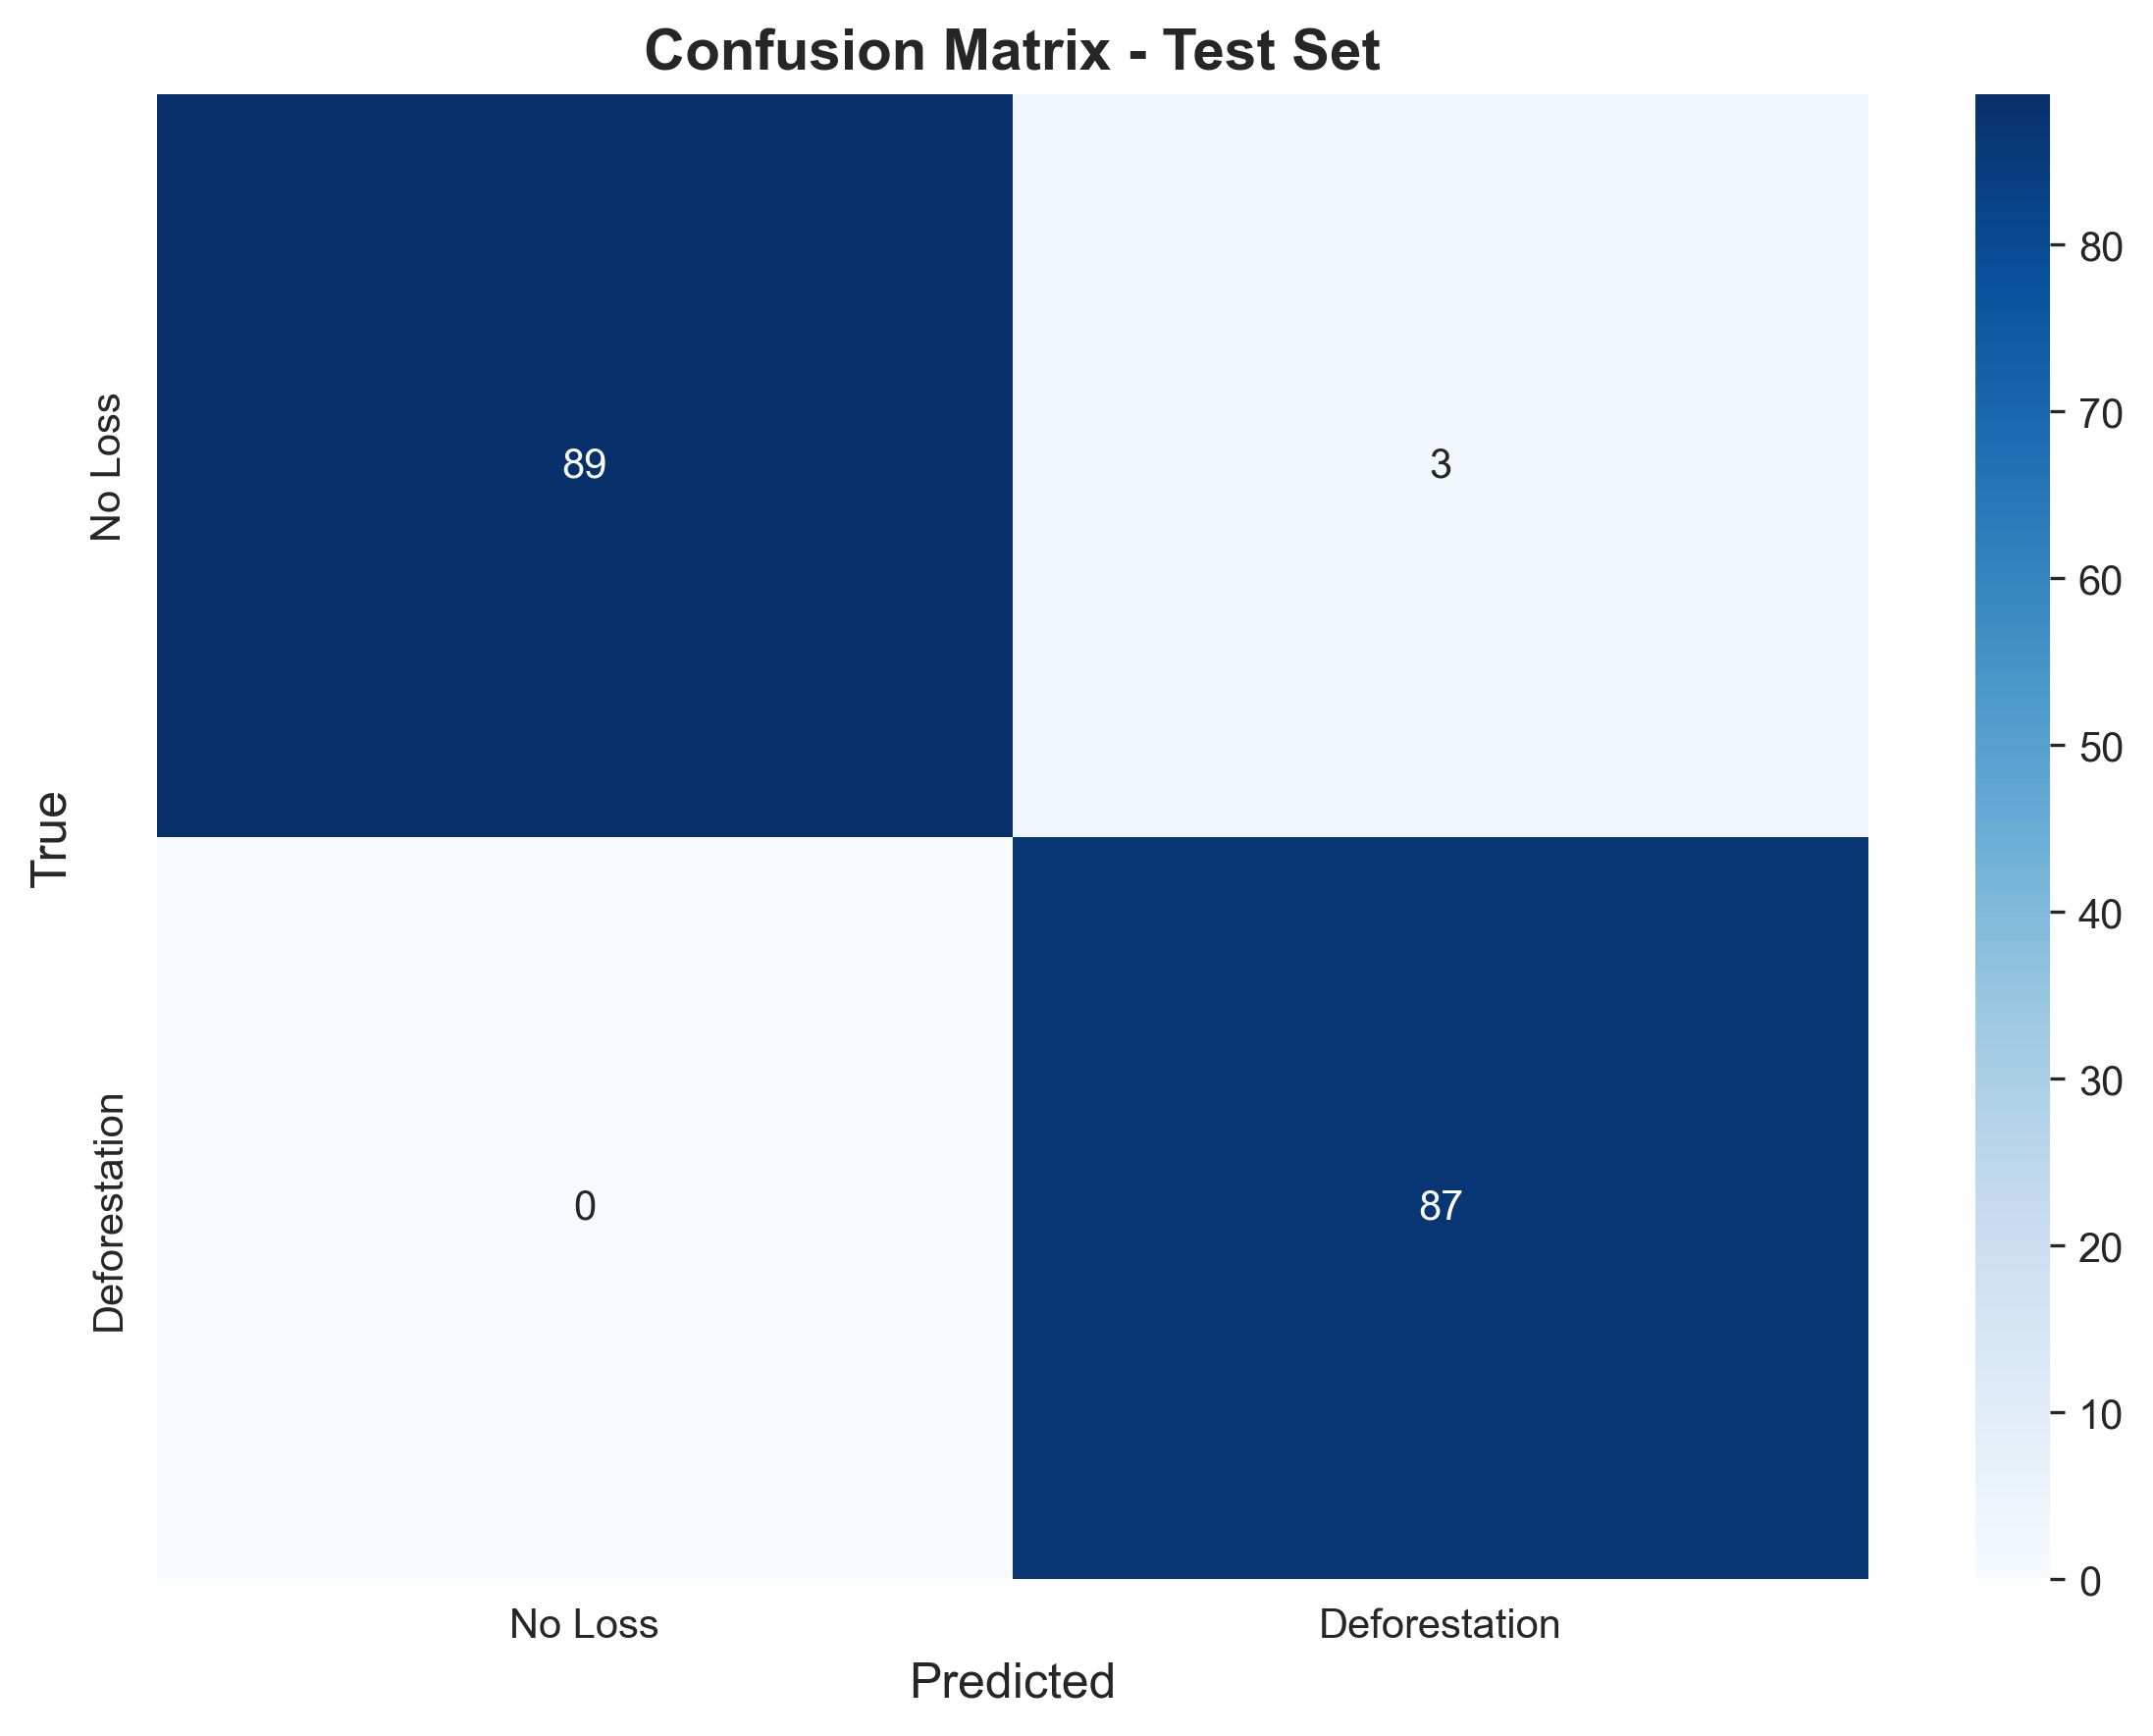

Classification Report:
               precision    recall  f1-score   support

      No Loss       1.00      0.97      0.98        92
Deforestation       0.97      1.00      0.98        87

     accuracy                           0.98       179
    macro avg       0.98      0.98      0.98       179
 weighted avg       0.98      0.98      0.98       179



In [12]:
# Compute confusion matrix
cm = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Loss', 'Deforestation'],
            yticklabels=['No Loss', 'Deforestation'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/plots/cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Classification Report:")
print(classification_report(test_metrics['labels'], test_metrics['predictions'],
                          target_names=['No Loss', 'Deforestation']))

### ROC Curve

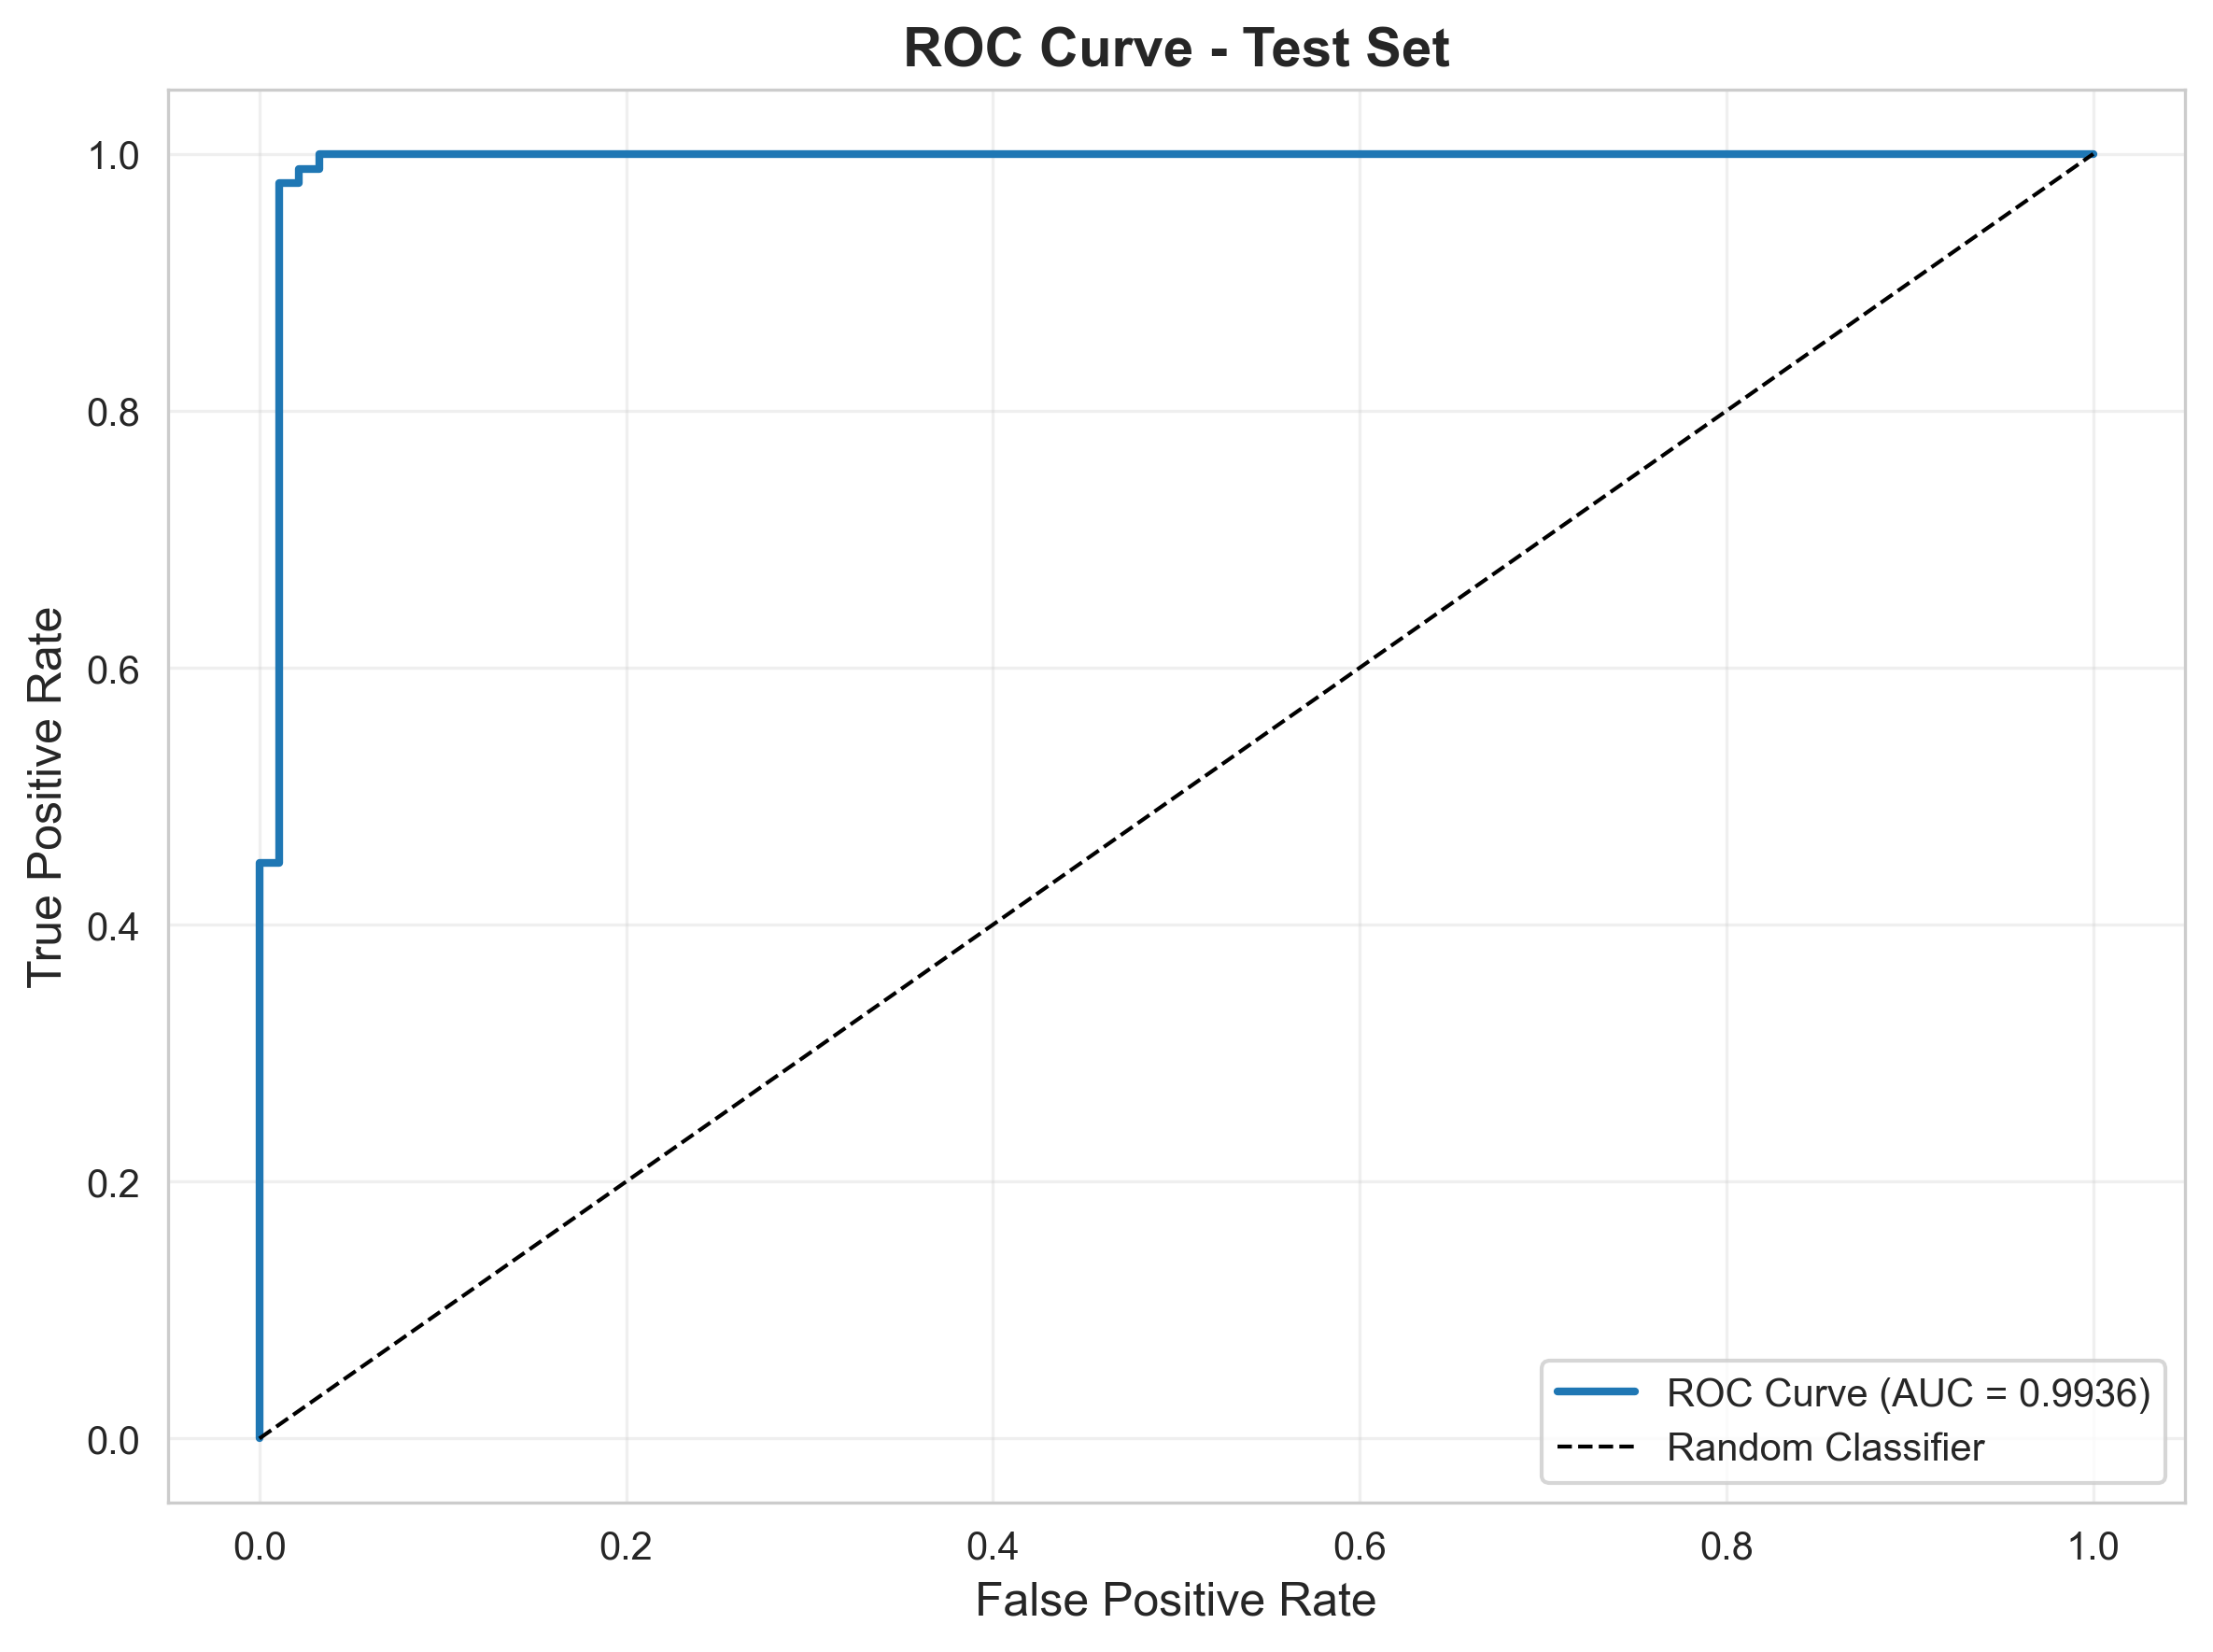

In [13]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_metrics['labels'], test_metrics['probabilities'][:, 1])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {test_metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/plots/cnn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 9️⃣ Predict Full Raster

**Note:** This step may take 10-15 minutes

In [14]:
from deep_learning.predict import RasterPredictor

print("Creating raster predictor...")
predictor = RasterPredictor(
    model=model,
    device=CONFIG['device'],
    patch_size=CONFIG['patch_size'],
    batch_size=CONFIG['pred_batch_size']
)

print("\nPredicting full raster...")
print("(This may take 10-15 minutes)\n")

prediction_start = time.time()

# Use training normalization stats for consistent prediction
classification_map, probability_map = predictor.predict_raster(
    feature_stack,
    valid_mask,
    stride=CONFIG['pred_stride'],
    normalize=True,
    normalization_stats=normalization_stats  # ✅ Use training stats
)

prediction_time = time.time() - prediction_start
print(f"\n✓ Prediction completed in {prediction_time/60:.2f} minutes")

2025-11-08 00:38:41 - deep_learning.predict - INFO - RasterPredictor initialized on device: cuda
2025-11-08 00:38:41 - deep_learning.predict - INFO - 
2025-11-08 00:38:41 - deep_learning.predict - INFO - PREDICTING FULL RASTER WITH CNN
2025-11-08 00:38:41 - deep_learning.predict - INFO - ======================================================================
2025-11-08 00:38:41 - deep_learning.predict - INFO - Raster shape: 10917 x 12547
2025-11-08 00:38:41 - deep_learning.predict - INFO - Patch size: 3x3
2025-11-08 00:38:41 - deep_learning.predict - INFO - Stride: 1
2025-11-08 00:38:41 - deep_learning.predict - INFO - Batch size: 1000
2025-11-08 00:38:41 - deep_learning.predict - INFO - 
Extracting patches...
2025-11-08 00:38:41 - deep_learning.patch_extractor - INFO - 
Extracting patches for full raster prediction...
2025-11-08 00:38:41 - deep_learning.patch_extractor - INFO - Raster shape: 10917 x 12547
2025-11-08 00:38:41 - deep_learning.patch_extractor - INFO - Patch size: 3x3, str

Creating raster predictor...

Predicting full raster...
(This may take 10-15 minutes)



2025-11-08 00:49:04 - deep_learning.patch_extractor - INFO - Extracted 14287923 valid patches
2025-11-08 00:49:06 - deep_learning.predict - INFO - Normalizing patches...
2025-11-08 00:49:06 - deep_learning.predict - INFO - Using training normalization statistics
2025-11-08 00:50:26 - deep_learning.predict - INFO - 
Predicting 14287923 patches...
2025-11-08 00:53:04 - deep_learning.predict - INFO - Filling output maps...
2025-11-08 00:53:19 - deep_learning.predict - INFO - Applying valid mask...
2025-11-08 00:53:20 - deep_learning.predict - INFO - 
2025-11-08 00:53:20 - deep_learning.predict - INFO - PREDICTION SUMMARY
2025-11-08 00:53:20 - deep_learning.predict - INFO - ======================================================================
2025-11-08 00:53:20 - deep_learning.predict - INFO - Total valid pixels: 15,569,516
2025-11-08 00:53:20 - deep_learning.predict - INFO - Deforestation pixels: 1,874,089 (12.04%)
2025-11-08 00:53:20 - deep_learning.predict - INFO - No deforestation pi


✓ Prediction completed in 14.69 minutes


### Save Results

In [15]:
# Save rasters
print("Saving results...")

output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)
(output_dir / 'rasters').mkdir(exist_ok=True)
(output_dir / 'models').mkdir(exist_ok=True)
(output_dir / 'data').mkdir(exist_ok=True)
(output_dir / 'plots').mkdir(exist_ok=True)

# Save rasters
predictor.save_rasters(
    output_dir / 'rasters' / 'cnn_classification.tif',
    output_dir / 'rasters' / 'cnn_probability.tif',
    metadata['s2_before']
)

# Save model
trainer.save_model(output_dir / 'models' / 'cnn_model.pth')

# Save metrics
metrics_to_save = {
    'accuracy': float(test_metrics['accuracy']),
    'precision': float(test_metrics['precision']),
    'recall': float(test_metrics['recall']),
    'f1_score': float(test_metrics['f1_score']),
    'roc_auc': float(test_metrics['roc_auc'])
}

with open(output_dir / 'data' / 'cnn_evaluation_metrics.json', 'w') as f:
    json.dump(metrics_to_save, f, indent=2)

# Save training history
with open(output_dir / 'data' / 'cnn_training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# Save patches
np.savez_compressed(
    output_dir / 'data' / 'cnn_training_patches.npz',
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test
)

print("\n✓ All results saved to: ../results/")

2025-11-08 00:53:22 - deep_learning.predict - INFO - 
Saving output rasters...


Saving results...


2025-11-08 00:53:23 - deep_learning.predict - INFO -   Classification raster saved: ..\results\rasters\cnn_classification.tif
2025-11-08 00:53:28 - deep_learning.predict - INFO -   Probability raster saved: ..\results\rasters\cnn_probability.tif
2025-11-08 00:53:28 - deep_learning.train - INFO - Model saved to: ..\results\models\cnn_model.pth



✓ All results saved to: ../results/


---
## 🔟 Visualization

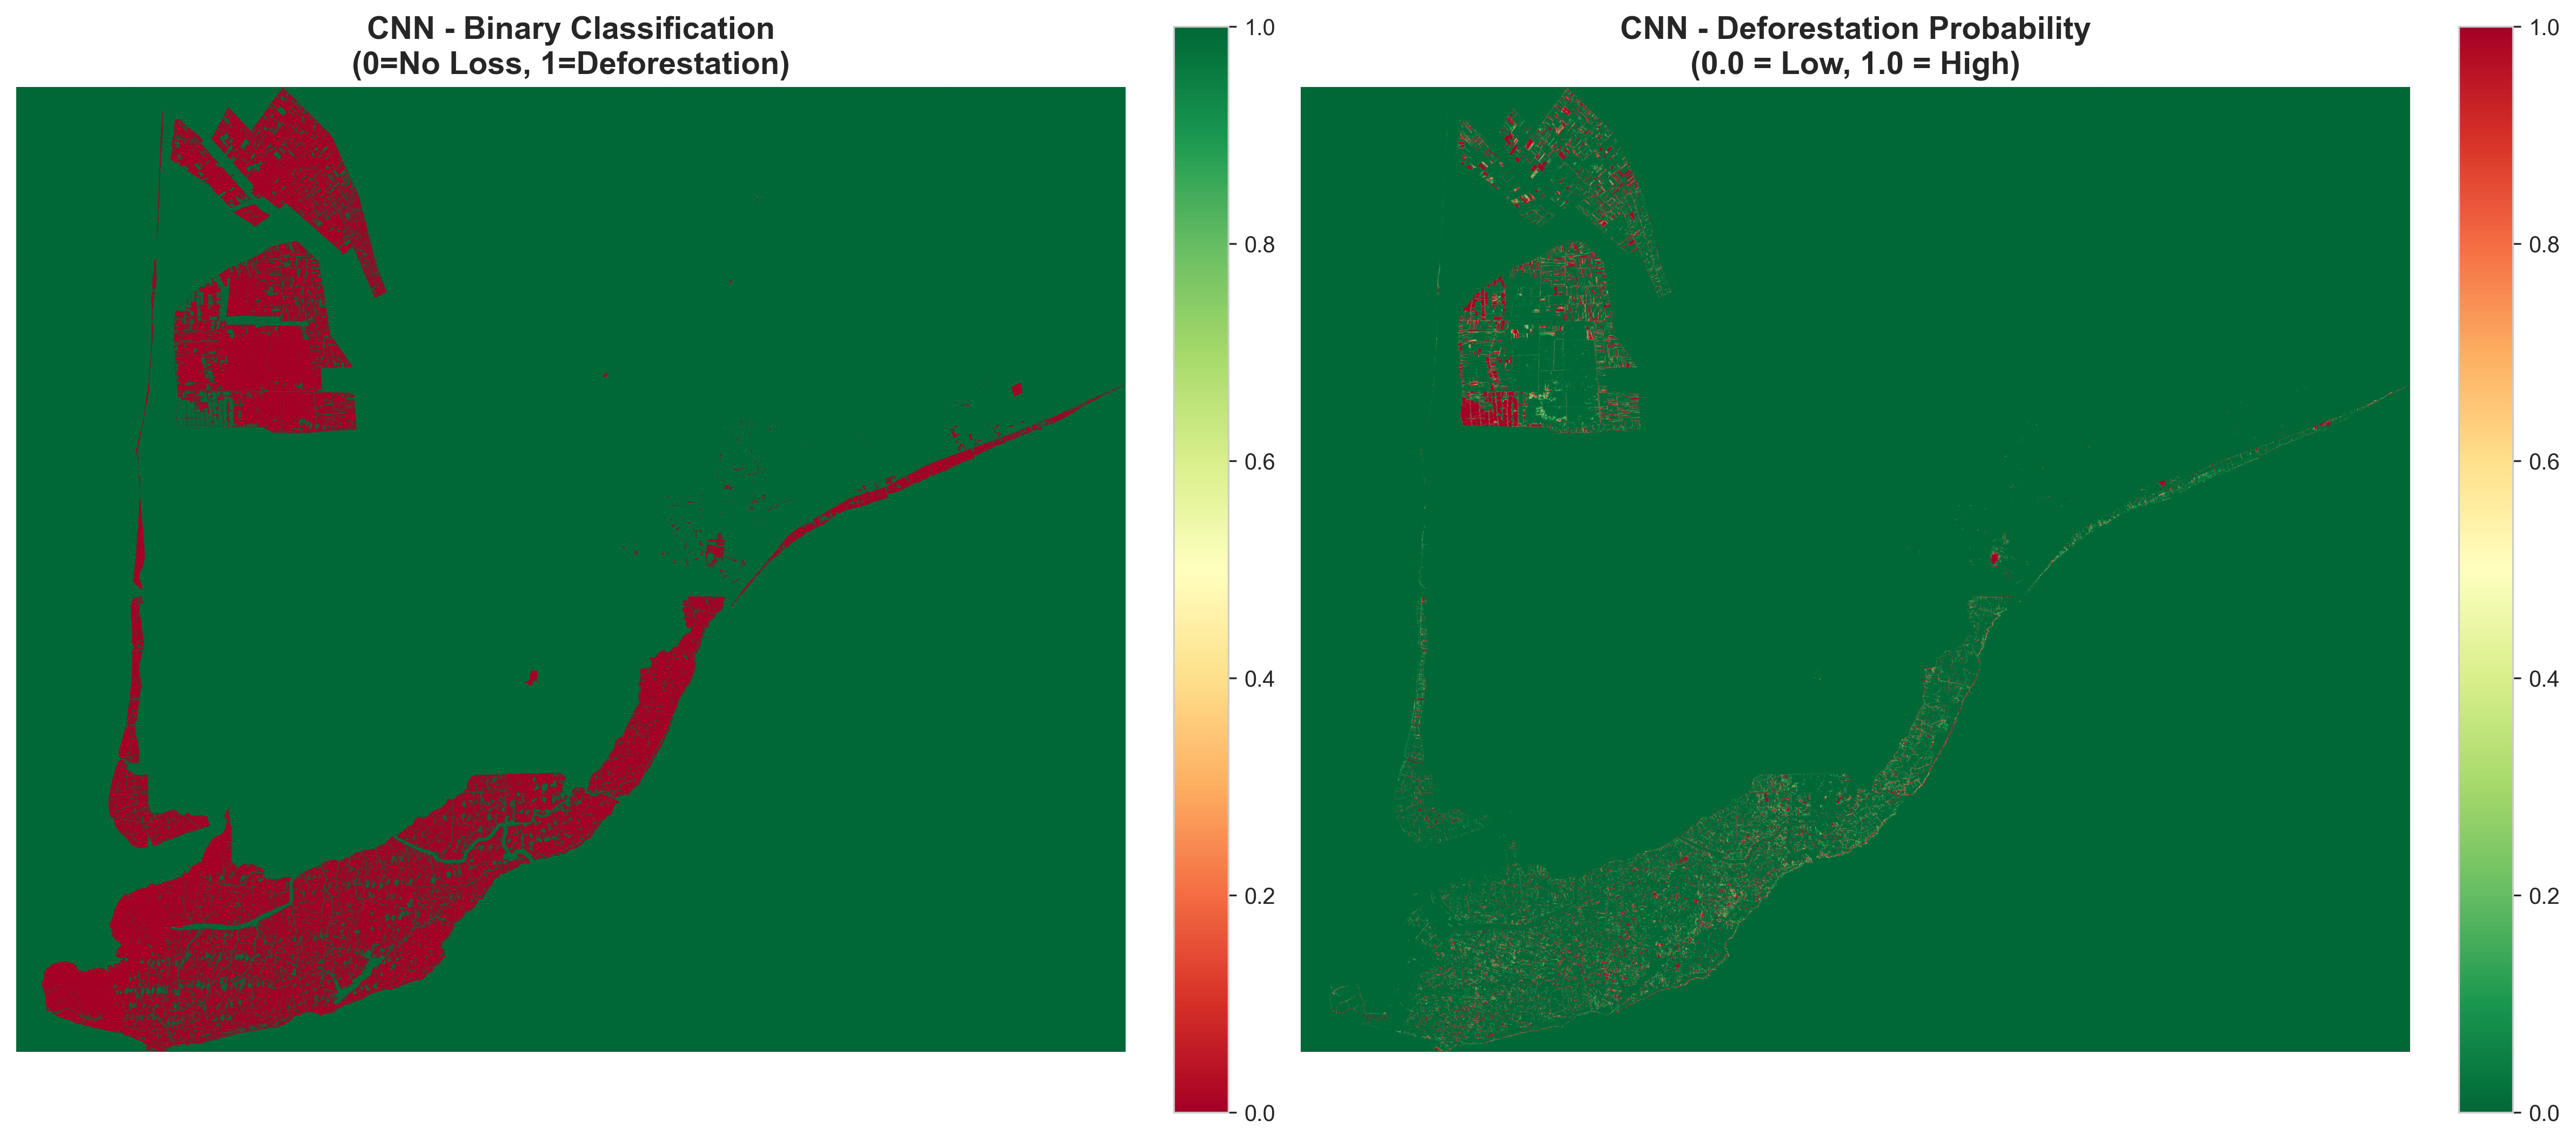


Classification Statistics:
  Total valid pixels: 15,569,516
  Deforestation pixels: 1,874,089 (12.04%)
  No deforestation pixels: 13,695,427 (87.96%)


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Classification map
im1 = axes[0].imshow(classification_map, cmap='RdYlGn', vmin=0, vmax=1)
axes[0].set_title('CNN - Binary Classification\n(0=No Loss, 1=Deforestation)', 
                 fontsize=14, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Probability map
im2 = axes[1].imshow(probability_map, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[1].set_title('CNN - Deforestation Probability\n(0.0 = Low, 1.0 = High)', 
                 fontsize=14, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('../results/plots/cnn_classification_maps.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics
deforestation_pixels = np.sum(classification_map == 1)
total_valid = np.sum(valid_mask)
deforestation_pct = deforestation_pixels / total_valid * 100

print(f"\nClassification Statistics:")
print(f"  Total valid pixels: {total_valid:,}")
print(f"  Deforestation pixels: {deforestation_pixels:,} ({deforestation_pct:.2f}%)")
print(f"  No deforestation pixels: {total_valid - deforestation_pixels:,} ({100-deforestation_pct:.2f}%)")

---
## 📊 Final Summary

In [17]:
print("\n" + "="*70)
print("CNN DEFORESTATION DETECTION - FINAL SUMMARY")
print("="*70)

print("\n📊 MODEL PERFORMANCE (Test Set):")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"  Precision: {test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)")
print(f"  Recall:    {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f} ({test_metrics['f1_score']*100:.2f}%)")
print(f"  ROC-AUC:   {test_metrics['roc_auc']:.4f} ({test_metrics['roc_auc']*100:.2f}%)")

print("\n⏱️  EXECUTION TIMES:")
print(f"  Training:   {training_time/60:7.2f} minutes")
print(f"  Prediction: {prediction_time/60:7.2f} minutes")
print(f"  Total:      {(training_time + prediction_time)/60:7.2f} minutes")

print("\n📁 OUTPUT FILES:")
print(f"  Classification map: ../results/rasters/cnn_classification.tif")
print(f"  Probability map:    ../results/rasters/cnn_probability.tif")
print(f"  Trained model:      ../results/models/cnn_model.pth")
print(f"  Metrics:            ../results/data/cnn_evaluation_metrics.json")
print(f"  Training history:   ../results/data/cnn_training_history.json")
print(f"  Patches:            ../results/data/cnn_training_patches.npz")

print("\n✅ CNN PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70 + "\n")


CNN DEFORESTATION DETECTION - FINAL SUMMARY

📊 MODEL PERFORMANCE (Test Set):
  Accuracy:  0.9832 (98.32%)
  Precision: 0.9667 (96.67%)
  Recall:    1.0000 (100.00%)
  F1-Score:  0.9831 (98.31%)
  ROC-AUC:   0.9936 (99.36%)

⏱️  EXECUTION TIMES:
  Training:      0.10 minutes
  Prediction:   14.69 minutes
  Total:        14.80 minutes

📁 OUTPUT FILES:
  Classification map: ../results/rasters/cnn_classification.tif
  Probability map:    ../results/rasters/cnn_probability.tif
  Trained model:      ../results/models/cnn_model.pth
  Metrics:            ../results/data/cnn_evaluation_metrics.json
  Training history:   ../results/data/cnn_training_history.json
  Patches:            ../results/data/cnn_training_patches.npz

✅ CNN PIPELINE COMPLETED SUCCESSFULLY!



---
## 🎓 Key Takeaways

### 1. **Spatial Context với Patches 3×3**
- Thay vì nhìn 1 pixel đơn lẻ → nhìn cả vùng lân cận 3×3
- CNN học được spatial patterns
- Kết quả mượt mà hơn (giảm nhiễu "lấm tấm")

### 2. **Spatial-Aware Splitting**
- Cluster các points gần nhau (<50m)
- Split theo cluster → tránh data leakage
- Đánh giá realistic trên vùng chưa thấy

### 3. **Regularization cho Small Dataset**
- Dataset nhỏ (chỉ 1,285 samples)
- Heavy regularization:
  - Dropout (0.5)
  - BatchNorm
  - Weight decay (L2)
  - Early stopping
- Model nhỏ (~50K parameters)

### 4. **Training Insights**
- Early stopping thường kick in sau ~15-25 epochs
- Learning rate scheduler tự động giảm LR khi plateau
- Class weights giúp handle imbalanced data

### 5. **Practical Notes**
- GPU: ~15-20 phút training + 10 phút prediction
- CPU: ~30-40 phút training + 15 phút prediction
- Kết quả có thể vary ±2-3% do stochastic nature

---

**Notebook hoàn thành! 🎉**

**Next steps:**
- So sánh với Random Forest (xem notebook riêng)
- Thử data augmentation nếu muốn improve thêm
- Analyze error cases để hiểu model behavior